# **FLIGHT-FARE PREDICTION**

For a traveller it is important to know the fare value of a trip, and as prices of flight ticket varies abruptly and it becomes hectic for a user to check different websites, use different deals. A flight fare prediction model will help inform the travellers with the optimal time to buy their flight tickets and understand trends in the airline industry.

# **STEPS**
1. We will be using train and test data. Test data is similar to train data minus the ‘price’ column.
2.We can do some data pre-processing and remove variables which are not needed and add some new features like ‘Booking_class’ and ‘market_share’ which will indicate the market share of each airline.
3. Next step is Feature generation, here we mainly work on the data and do some transformations to extract unknown variables or create different bons of particular columns and clean the messy data.
4. Do some EDA, data visualisation to understand the relationship between different independent variables and the relationship between the independent variables and the dependent variables...*For the eda part you can refer my other kaggle file* [Statistical Analysis & EDA for flight fare](https://www.kaggle.com/ananyanandi02/statistical-analysis-eda-for-flight-fare)

# **BUILDING OUR MODEL**
5. Finally after the above steps, we can deploy the  model and evaluate the efficiency of the predictions.


---

# MODELS USED:
*   Random Forest : **90.04%**
*   KNN : **75.7%**
*   Xgboost : **87.48%**
*   Gradientboost : **87.59%**

[MACHINE HACK FLIGHT FARE PREDICTION HACKATHON PUBLIC LEADERBOARD ACCURACY SCORE](https://www.machinehack.com/hackathons/predict_the_flight_ticket_price_hackathon ) : **93:14%**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_excel('../input/flight-fare-prediction-mh/Data_Train.xlsx')
test= pd.read_excel('../input/flight-fare-prediction-mh/Test_set.xlsx')

In [3]:
train.shape

(10683, 11)

In [4]:
test.shape

(2671, 10)

In [5]:
train.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [6]:
print(train.dtypes)
print(test.dtypes)

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object
Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
dtype: object


In [7]:
print(train.isnull().sum()) #checking for null values
print(test.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64


In [8]:
train=train.dropna()

In [9]:
train.drop_duplicates()
train.shape

(10682, 11)

## FEATURE EXTRACTION

### Extracting day,month,weekday from Date of Journey

In [10]:
train['Journey_Day'] = pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.day
train['Journey_Month'] = pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.month
train['weekday']= pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.weekday

test['Journey_Day'] = pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.day
test['Journey_Month'] = pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.month
test['weekday']= pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.weekday

In [11]:
train.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)
test.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [12]:
train.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time',
       'Duration', 'Total_Stops', 'Additional_Info', 'Price', 'Journey_Day',
       'Journey_Month', 'weekday'],
      dtype='object')

### Converting duration into minutes

In [13]:
def duration(test):
    test = test.strip()
    total=test.split(' ')
    to=total[0]
    hrs=(int)(to[:-1])*60
    if((len(total))==2):
        mint=(int)(total[1][:-1])
        hrs=hrs+mint
    test=str(hrs)
    return test
train['Duration']=train['Duration'].apply(duration)
test['Duration']=test['Duration'].apply(duration)

### Extracting whether its a morning,evening,night or afternoon flight from departure time & arrival time of the flight

In [14]:
def deparrtime(x):
    x=x.strip()
    tt=(int)(x.split(':')[0])
    if(tt>=16 and tt<21):
        x='Evening'
    elif(tt>=21 or tt<5):
        x='Night'
    elif(tt>=5 and tt<11):
        x='Morning'
    elif(tt>=11 and tt<16):
        x='Afternoon'
    return x
train['Dep_Time']=train['Dep_Time'].apply(deparrtime)
test['Dep_Time']=test['Dep_Time'].apply(deparrtime)
train['Arrival_Time']=train['Arrival_Time'].apply(deparrtime)
test['Arrival_Time']=test['Arrival_Time'].apply(deparrtime)

### Converting total_stops to 0,1,2,3 and so on..

In [15]:
def stops(x):
    if(x=='non-stop'):
        x=str(0)
    else:
        x.strip()
        stps=x.split(' ')[0]
        x=stps
    return x
train['Total_Stops']=train['Total_Stops'].apply(stops)
test['Total_Stops']=test['Total_Stops'].apply(stops)

In [16]:
pd.options.mode.chained_assignment = None 
for i in range(train.shape[0]):
    if(train.iloc[i]['Additional_Info']=='No info'):
        train.iloc[i]['Additional_Info']='No Info' 

In [17]:
pd.options.mode.chained_assignment = None 
for i in range(test.shape[0]):
    if(test.iloc[i]['Additional_Info']=='No info'):
        test.iloc[i]['Additional_Info']='No Info' 

In [18]:
train=train.drop(['Route'], axis=1) #we don't need it as we already have total_stops
test=test.drop(['Route'], axis=1)

In [19]:
train.head(2)

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday
0,IndiGo,Banglore,New Delhi,Night,Night,170,0,No info,3897,24,3,6
1,Air India,Kolkata,Banglore,Morning,Afternoon,445,2,No info,7662,1,5,2


In [20]:
test.head(2)

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_Day,Journey_Month,weekday
0,Jet Airways,Delhi,Cochin,Evening,Night,655,1,No info,6,6,3
1,IndiGo,Kolkata,Banglore,Morning,Morning,240,1,No info,12,5,6


In [21]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Source           10682 non-null  object
 2   Destination      10682 non-null  object
 3   Dep_Time         10682 non-null  object
 4   Arrival_Time     10682 non-null  object
 5   Duration         10682 non-null  object
 6   Total_Stops      10682 non-null  object
 7   Additional_Info  10682 non-null  object
 8   Price            10682 non-null  int64 
 9   Journey_Day      10682 non-null  int64 
 10  Journey_Month    10682 non-null  int64 
 11  weekday          10682 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airl

### Checking the relationship between Dept_time and Price

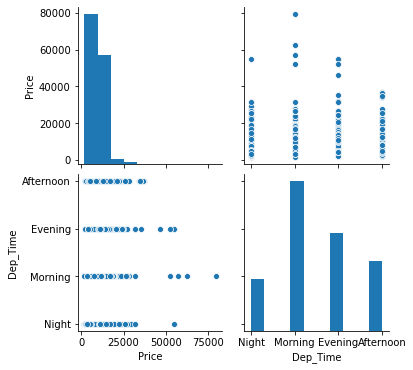

In [22]:
sns.pairplot(data=train,vars=['Price','Dep_Time'])

In [23]:
#price outlier check
Q1=train['Price'].quantile(0.25)
Q3=train['Price'].quantile(0.75)
IQR=Q3-Q1

print(Q1)
print(Q3)
print(IQR)

5277.0
12373.0
7096.0


In [24]:
#price outlier removed
train=train[~((train['Price']>Q3+1.5*IQR)|(train['Price']<Q1-1.5*IQR))]

In [25]:
train.shape

(10588, 12)

In [26]:
train["Duration"] = train["Duration"].astype(int)
test["Duration"] = test["Duration"].astype(int)
train["Journey_Day"] = train["Journey_Day"].astype(object)
test["Journey_Day"] = test["Journey_Day"].astype(object)
train["Journey_Month"] = train["Journey_Month"].astype(object)
test["Journey_Month"] = test["Journey_Month"].astype(object)
train["weekday"] = train["weekday"].astype(object)
test["weekday"] = test["weekday"].astype(object)

### Correlation Analysis between duration(continuous independent variable and price)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


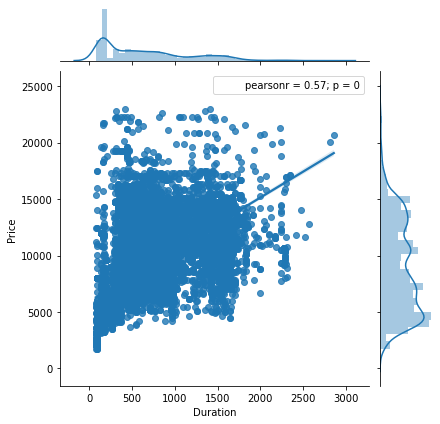

In [27]:
import scipy.stats as stats
_ = sns.jointplot(x='Duration',y='Price',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

In [28]:
# Import label encoder 
colnames = list(train.columns)
from sklearn import preprocessing 

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for col in colnames:
    if train[col].dtype==object:
        train[col]= label_encoder.fit_transform(train[col]) 

In [29]:
train.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday
0,3,0,5,3,3,170,0,5,3897,8,0,6
1,1,3,0,2,0,445,2,5,7662,0,2,2
2,4,2,1,2,3,1140,2,5,13882,3,3,6
3,3,3,0,1,3,325,1,5,6218,4,2,6
4,3,0,5,1,3,285,1,5,13302,0,0,4


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Airline          10588 non-null  int64
 1   Source           10588 non-null  int64
 2   Destination      10588 non-null  int64
 3   Dep_Time         10588 non-null  int64
 4   Arrival_Time     10588 non-null  int64
 5   Duration         10588 non-null  int64
 6   Total_Stops      10588 non-null  int64
 7   Additional_Info  10588 non-null  int64
 8   Price            10588 non-null  int64
 9   Journey_Day      10588 non-null  int64
 10  Journey_Month    10588 non-null  int64
 11  weekday          10588 non-null  int64
dtypes: int64(12)
memory usage: 1.1 MB


### Convert into proper datatypes

In [31]:
train["weekday"] = train["weekday"].astype(object)
train["Dep_Time"] = train["Dep_Time"].astype(object)
train["Airline"]=train["Airline"].astype(object)
train["Source"]=train["Source"].astype(object)
train["Destination"]=train["Destination"].astype(object)
train["Arrival_Time"]=train["Arrival_Time"].astype(object)
train["Total_Stops"]=train["Total_Stops"].astype(object)
train["Additional_Info"]=train["Additional_Info"].astype(object)
train["Journey_Day"]=train["Journey_Day"].astype(object)
train["Journey_Month"]=train["Journey_Month"].astype(object)

In [33]:
train.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday
0,3,0,5,3,3,170,0,5,3897,8,0,6
1,1,3,0,2,0,445,2,5,7662,0,2,2
2,4,2,1,2,3,1140,2,5,13882,3,3,6
3,3,3,0,1,3,325,1,5,6218,4,2,6
4,3,0,5,1,3,285,1,5,13302,0,0,4


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10588 non-null  object
 1   Source           10588 non-null  object
 2   Destination      10588 non-null  object
 3   Dep_Time         10588 non-null  object
 4   Arrival_Time     10588 non-null  object
 5   Duration         10588 non-null  int64 
 6   Total_Stops      10588 non-null  object
 7   Additional_Info  10588 non-null  object
 8   Price            10588 non-null  int64 
 9   Journey_Day      10588 non-null  object
 10  Journey_Month    10588 non-null  object
 11  weekday          10588 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [35]:
#for test data
# Import label encoder 
colnames = list(test.columns)
from sklearn import preprocessing 

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for col in colnames:
    if test[col].dtype==object:
        test[col]= label_encoder.fit_transform(test[col]) 

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Airline          2671 non-null   int64
 1   Source           2671 non-null   int64
 2   Destination      2671 non-null   int64
 3   Dep_Time         2671 non-null   int64
 4   Arrival_Time     2671 non-null   int64
 5   Duration         2671 non-null   int64
 6   Total_Stops      2671 non-null   int64
 7   Additional_Info  2671 non-null   int64
 8   Journey_Day      2671 non-null   int64
 9   Journey_Month    2671 non-null   int64
 10  weekday          2671 non-null   int64
dtypes: int64(11)
memory usage: 229.7 KB


In [37]:
test["weekday"] = test["weekday"].astype(object)
test["Dep_Time"] = test["Dep_Time"].astype(object)
test["Airline"]=test["Airline"].astype(object)
test["Source"]=test["Source"].astype(object)
test["Destination"]=test["Destination"].astype(object)
test["Arrival_Time"]=test["Arrival_Time"].astype(object)
test["Total_Stops"]=test["Total_Stops"].astype(object)
test["Additional_Info"]=test["Additional_Info"].astype(object)
test["Journey_Day"]=test["Journey_Day"].astype(object)
test["Journey_Month"]=test["Journey_Month"].astype(object)

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Source           2671 non-null   object
 2   Destination      2671 non-null   object
 3   Dep_Time         2671 non-null   object
 4   Arrival_Time     2671 non-null   object
 5   Duration         2671 non-null   int64 
 6   Total_Stops      2671 non-null   object
 7   Additional_Info  2671 non-null   object
 8   Journey_Day      2671 non-null   object
 9   Journey_Month    2671 non-null   object
 10  weekday          2671 non-null   object
dtypes: int64(1), object(10)
memory usage: 229.7+ KB


In [39]:
test.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_Day,Journey_Month,weekday
0,4,2,1,1,3,655,1,5,2,3,3
1,3,3,0,2,2,240,1,5,4,2,6
2,4,2,1,1,1,1425,1,3,7,2,1
3,6,2,1,2,3,780,1,5,7,2,1
4,0,0,2,3,3,170,0,5,8,3,0


In [40]:
from sklearn import preprocessing

In [41]:
train["Duration"]= (train["Duration"] - train["Duration"].mean())/train["Duration"].std()   #standardizing
test["Duration"]= (test["Duration"] - test["Duration"].mean())/test["Duration"].std()

In [42]:
X=train.drop(["Price"],axis=1)
Y=train["Price"]
x=np.array(X)
y=np.array(Y)

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [44]:
gbm = GradientBoostingRegressor()
xgb = XGBRegressor()

In [45]:
best_gbm = GridSearchCV(gbm, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[1,2,3],'n_estimators':[100,200,500]}, cv=5, n_jobs=-1)
best_xgb = GridSearchCV(xgb, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[1,2,3],'n_estimators':[100,200,500]}, cv=5, n_jobs=-1)

In [46]:
best_gbm.fit(x,y)
best_xgb.fit(x,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [47]:
scores = cross_val_score(best_gbm.best_estimator_, x, y, cv=5)
print("GBM Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
scores = cross_val_score(best_xgb.best_estimator_, x, y, cv=5)
print("XGBoost Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

GBM Cross validation score: 87.59% (+/- 0.51%)
XGBoost Cross validation score: 87.48% (+/- 0.70%)


In [48]:
#KNN
number_of_neighbors = range(1,20)
params = {'n_neighbors':number_of_neighbors}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5) 
model.fit(x,y)
scores = cross_val_score(model, x, y, cv=5)
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Cross validation score: 75.73% (+/- 3.03%)


In [49]:
#Random Forest
parameters = {'n_estimators':[500], "max_features" : ["auto", "log2", "sqrt"],"bootstrap": [True, False]}
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
clf.fit(x, y)
scores = cross_val_score(clf, x, y, cv=5)
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Cross validation score: 90.02% (+/- 1.11%)


In [50]:
x=np.array(test)

In [51]:
ypred=clf.predict(x)

In [53]:
test= pd.read_excel('../input/flight-fare-prediction-mh/Test_set.xlsx')
test["Price"]=ypred

In [54]:
test.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [55]:
test=test.drop(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],axis=1)

In [56]:
test.head()

,Price
0,14715.680000
1,4461.172000
2,12898.000000
3,12837.198833
4,3700.736000
